# AI Challenge - Team Beer
## Implementing a 2-Layer Neural Network for predicting contract renewal probabilities
## Model 3
### March 29, 2018 - tikoehle@cisco.com

# Setup the environment
This notebook runs on Python 3.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pull files from Google Drive into Colab environment

In [13]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the file-id's of contents in my drive.
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

# Download a file based on its file-id.
file_id = '1qZsps2I5PPh4hN9jzBSqSliYsKLnDJfq'
data = drive.CreateFile({'id': file_id})
# GetContentFile pulls the file from Drive and saves it in the Google Colab 
# environment and sets the names of the files.
data.GetContentFile('pandas_cleanup_model3.csv')

# Import the neural_net module from Drive into Colab.
file_id = '1nZ5MesLlOxJy151oSauYJ3YhOIX_CAWl'
neural_net = drive.CreateFile({'id': file_id})
neural_net.GetContentFile('neural_net.py')
from neural_net import TwoLayerNet

title: classifier_teambeer-model_3_colab.ipynb, id: 1_82BZP0jr3IFjFtkBjCXygPwS2YLgSeW
title: neural_net.py, id: 1nZ5MesLlOxJy151oSauYJ3YhOIX_CAWl
title: pandas_cleanup_model3.csv, id: 1qZsps2I5PPh4hN9jzBSqSliYsKLnDJfq
title: Colab Notebooks, id: 1bld83iUDR5glQ43eXq7PatT7kMZQEfle


# Load and sub-sample the data
The data is based on the file challengeData.tsv downloaded March 22, 2018.

In [3]:
import pandas as pd
import io
import os.path

k = 0  # PCA, number of principal components

def load_csv():
    df = pd.read_csv('pandas_cleanup_model3.csv')
    drop_list = [ \
                'Unnamed: 0', \
                'challenge_data.minor_line_yorn', \
                #'challenge_data.software_yorn', \
                #'challenge_data.default_multi_year_discount_yorn', \
                #'challenge_data.four_quarter_bookings_band_$100k < Tier <= $250k', \
                #'challenge_data.four_quarter_bookings_band_$10m < Tier <= $25m', \
                #'challenge_data.four_quarter_bookings_band_$1m < Tier <= $5m', \
                #'challenge_data.four_quarter_bookings_band_$250k < Tier <= $500k', \
                #'challenge_data.four_quarter_bookings_band_$25m < Tier <= $50m', \
                #'challenge_data.four_quarter_bookings_band_$500k < Tier <= $1m', \
                #'challenge_data.four_quarter_bookings_band_$5m < Tier <= $10m', \
                #'challenge_data.four_quarter_bookings_band_Tier <= $100k', \
                #'challenge_data.four_quarter_bookings_band_Tier > $50m', \
                'challenge_data.product_route_to_market_2TIER', \
                'challenge_data.product_route_to_market_DIRECT', \
                'challenge_data.product_route_to_market_DVAR', \
                'challenge_data.product_route_to_market_OTHER', \
                'challenge_data.product_route_to_market_SP', \
                'challenge_data.service_route_to_market_code_2TIER', \
                'challenge_data.service_route_to_market_code_DIRECT', \
                'challenge_data.service_route_to_market_code_DVAR', \
                'challenge_data.service_route_to_market_code_OTHER', \
                'challenge_data.service_route_to_market_code_SP' \
                ]
    df.drop(drop_list, axis=1, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)
    df_data = df.loc[:, df.columns != 'challenge_data.renewed_yorn']
    df_label = df.loc[:, df.columns == 'challenge_data.renewed_yorn']
    
    # Verifying the Correlations.
    pd.set_option('display.width', 100)
    pd.set_option('precision', 3)
    correlations = df_data.corr(method='pearson')
    print(correlations)
    # Verifying the Skew of Univariate Distributions.
    skew = df_data.skew()
    print(skew)
    
    X = df_data.values
    y = df_label.values
    y = y.ravel()
    del df_label
    del df_data
    del df
    
    return X, y

def get_csv_data(num_training=78000, num_validation=10000, num_test=10000):
    """
    Load a pandas dataframe from csv file with pre-processed data.
    """
    X, y = load_csv()
    
    # Subsample the data.
    mask = list(range(num_training))
    X_train = X[mask]
    y_train = y[mask]
    mask = list(range(num_training, num_training + num_validation))
    X_val = X[mask]
    y_val = y[mask]
    mask = list(range(num_training + num_validation, num_training + num_validation + num_test))
    X_test = X[mask]
    y_test = y[mask]

    # Mean normalize.
    mean_value = np.mean(X_train, axis=0)
    X_train -= mean_value
    X_val -= mean_value
    X_test -= mean_value
    
    # Feature scale.
    sigma = np.std(X_train, axis = 0)
    X_train = np.divide(X_train, sigma, out=np.zeros_like(X_train), where=sigma!=0)
    X_val = np.divide(X_val, sigma, out=np.zeros_like(X_val), where=sigma!=0)
    X_test = np.divide(X_test, sigma, out=np.zeros_like(X_test), where=sigma!=0)
    
    # PCA
    global k
    k = 41
    #cov = np.dot(X_train.T, X_train) / X_train.shape[0]
    #U,S,V = np.linalg.svd(cov)
    #X_train_rot_reduced = np.dot(X_train, U[:,:k])
    #X_train = X_train_rot_reduced
    #X_val_rot_reduced = np.dot(X_val, U[:,:k]) 
    #X_val = X_val_rot_reduced
    #X_test_rot_reduced = np.dot(X_test, U[:,:k]) 
    #X_test = X_test_rot_reduced
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_csv_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

                                                    challenge_data.contract_line_multi_year_discount_yorn  \
challenge_data.contract_line_multi_year_discoun...                                              1.000       
challenge_data.default_multi_year_discount_yorn                                                -0.060       
challenge_data.software_yorn                                                                   -0.003       
challenge_data.software_support_services_eligib...                                              0.011       
challenge_data.contract_line_net_usd_amount                                                    -0.005       
challenge_data.product_net_price                                                               -0.007       
hist_renewal_sum                                                                               -0.225       
hist_renewal_rate                                                                              -0.304       
hist_mean_external_

Train data shape:  (78000, 41)
Train labels shape:  (78000,)
Validation data shape:  (10000, 41)
Validation labels shape:  (10000,)
Test data shape:  (10000, 41)
Test labels shape:  (10000,)


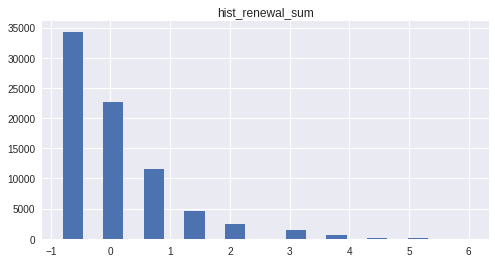

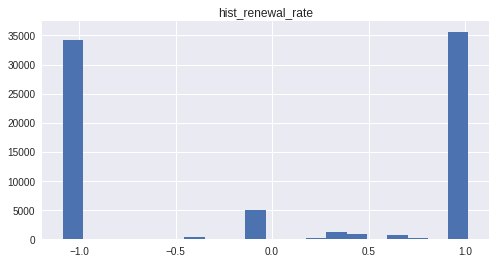

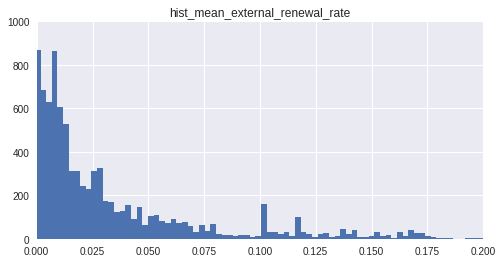

In [30]:
plt.rcParams['figure.figsize'] = (8.0, 4.0)
#plt.rcParams['image.interpolation'] = 'nearest'

plt.hist(X_train[:,6], bins=20)
plt.title("hist_renewal_sum")
plt.show()

plt.hist(X_train[:,7], bins=20)
plt.title("hist_renewal_rate")
plt.show()

plt.hist(X_train[:,8], bins='auto')
plt.axis([0,0.2,0,1000])
plt.title("hist_mean_external_renewal_rate")
plt.show()

## Test the network deployment 

Final training loss:  0.026671461070126943


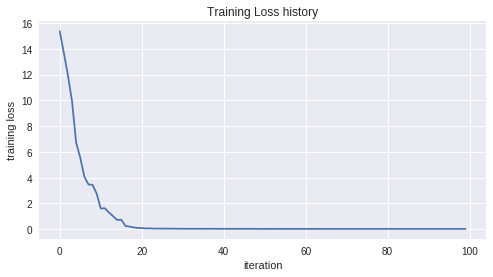

In [44]:
#from neural_net import TwoLayerNet

input_size = 1000
hidden_size = 200
num_classes = 2
num_inputs = 10

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()
stats = net.train(X, y, X, y, learning_rate=1e-4, reg=5e-6, num_iters=100, verbose=False)
print('Final training loss: ', stats['loss_history'][-1])

# Plot the loss function.
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Sanity checking the network implementation with sub-sampled real data

iteration 0 / 1000: loss 0.693147
iteration 100 / 1000: loss 0.077913
iteration 200 / 1000: loss 0.011241
iteration 300 / 1000: loss 0.004866
iteration 400 / 1000: loss 0.002894
iteration 500 / 1000: loss 0.001820
iteration 600 / 1000: loss 0.001624
iteration 700 / 1000: loss 0.001147
iteration 800 / 1000: loss 0.000868
iteration 900 / 1000: loss 0.000898
Initial training loss (Softmax/CE expect: -ln(1/num_classes) = -ln(0.5) = 0.69315): 0.693147
Final training loss: 0.000801


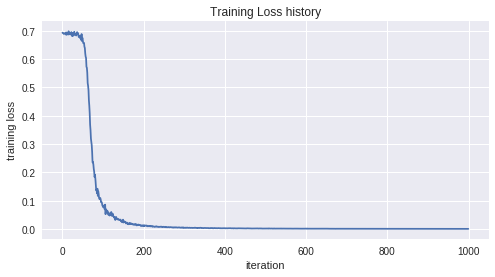

In [45]:
# Zero loss testing the network with 20 training examples (overfitting a tiny subset of data).
num_training_zero_loss = 20
num_validation_zero_loss = 10

mask = list(range(num_training_zero_loss))
X_train_zero_loss = X_train[mask]
y_train_zero_loss = y_train[mask]

mask = list(range(num_training_zero_loss, num_training_zero_loss + num_validation_zero_loss))
X_val_zero_loss = X_val[mask]
y_val_zero_loss = y_val[mask]

input_size = k
hidden_size = 400
num_classes = 2

net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train_zero_loss, y_train_zero_loss, X_val_zero_loss, y_val_zero_loss,
                  num_iters=1000, batch_size=400,
                  learning_rate=0.17, learning_rate_decay=1.0,
                  reg=0.0, verbose=True)

# Check if the initial loss is reasonable.
print('Initial training loss (Softmax/CE expect: -ln(1/num_classes) = -ln(0.5) = 0.69315): %f' 
      % (stats['loss_history'][0]))
print('Final training loss: %f' % (stats['loss_history'][-1]))

# Plot the loss function.
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Train the network with a larger subset of the real data

In [46]:
input_size = k
hidden_size = 400
num_classes = 2
net = TwoLayerNet(input_size, hidden_size, num_classes)
t1 = time.time()

# Train the network.
stats = net.train(X_train, y_train, X_val, y_val,
                  num_iters=2000, batch_size=1000,
                  learning_rate=0.84, learning_rate_decay=0.95,
                  reg=5e-5, verbose=True)
t2 = time.time()

# Predict on the validation set.
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: %f, computed in %fs' % (val_acc, t2 - t1))

# Softmax probabilities and Log Loss
probs, logloss = net.predict_softmax(X_val, y_val)
print('Validation Log Loss: %f' % (logloss))

iteration 0 / 2000: loss 0.693147
iteration 100 / 2000: loss 0.651913
iteration 200 / 2000: loss 0.611818
iteration 300 / 2000: loss 0.581892
iteration 400 / 2000: loss 0.559969
iteration 500 / 2000: loss 0.565551
iteration 600 / 2000: loss 0.581933
iteration 700 / 2000: loss 0.557885
iteration 800 / 2000: loss 0.568373
iteration 900 / 2000: loss 0.562410
iteration 1000 / 2000: loss 0.569593
iteration 1100 / 2000: loss 0.536252
iteration 1200 / 2000: loss 0.556923
iteration 1300 / 2000: loss 0.563728
iteration 1400 / 2000: loss 0.525375
iteration 1500 / 2000: loss 0.532892
iteration 1600 / 2000: loss 0.491701
iteration 1700 / 2000: loss 0.523965
iteration 1800 / 2000: loss 0.537007
iteration 1900 / 2000: loss 0.511878
Validation accuracy: 0.730500, computed in 33.733157s
Validation Log Loss: 0.527295


## Debug the training

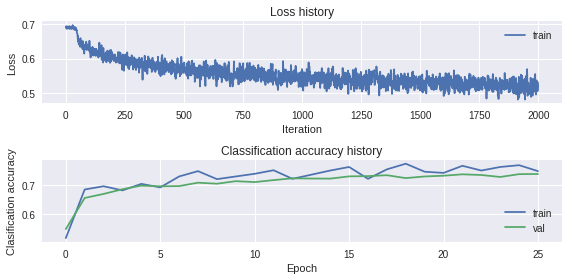

In [47]:
# Plot the loss function and train / validation accuracies.
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'], label='train')
plt.legend()
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.legend()
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.tight_layout()
plt.show()

## Tune Hyperparameters

In [35]:
best_net = None     # Store the best model into this 
best_stats = None   # Training stats of the best model
best_val = -1       # The highest validation accuracy that we have seen so far.
results = {}        # History buffer for plotting.
input_size = k      # Use with PCA, intialize the parameter W1 with k (number of principal components)
num_classes = 2
std=1e-6

# Hyperparameters
hidden_size = [400]
np.random.seed(2)
learning_rates = 10 ** np.random.uniform(0, 0.5, 20)
np.random.seed(3)
regularization_strengths = 10 ** np.random.uniform(-9, -5, 20)
num_iters = [2000]
batch_size = [200]

i = 0
num_train = X_train.shape[0]
max_iters = len(hidden_size) * len(learning_rates) * len(regularization_strengths) * \
            len(num_iters) * len(batch_size)
for h_size in hidden_size:
    for l_rate in learning_rates:
        for reg_strength in regularization_strengths:
            for n_iters in num_iters:
                for batch in batch_size:
                    i += 1
                    if batch >= n_iters:
                        continue
                    
                    # Create the network.
                    net = TwoLayerNet(input_size, h_size, num_classes, std)
                    # Train the network.
                    t1 = time.time()
                    stats = net.train(X_train, y_train, X_val, y_val, 
                                      num_iters=n_iters, batch_size=batch,
                                      learning_rate=l_rate, learning_rate_decay=0.95,
                                      reg=reg_strength, verbose=False)
                    t2 = time.time()
                    iterations_per_epoch = max(num_train / batch, 1)
                    epochs = int(n_iters / iterations_per_epoch)
                    print('\r%d/%d epochs:%d iter_ep:%.1f iters:%d batch:%d hid:%d learn:%f reg:%f t:%.1fs' 
                          % (i, max_iters, epochs, iterations_per_epoch, n_iters, batch, h_size, 
                             l_rate, reg_strength, t2 - t1), end='', flush=True)
                    
                    # Evaluate. Predict on the training set.
                    train_accuracy = (net.predict(X_train) == y_train).mean()
                    # Predict on the validation set.
                    val_accuracy = (net.predict(X_val) == y_val).mean()
                    if val_accuracy > best_val:
                        t3 = time.time()
                        best_val = val_accuracy
                        best_net = net
                        best_stats = stats
                        print('\nBest: hid:%d batch:%d learn:%e reg:%e train_accuracy:%f val_accuracy:%f t:%.1fs' 
                              % (h_size, batch, l_rate, reg_strength, train_accuracy, val_accuracy, t3 - t1))
                    
                    results[(l_rate, reg_strength)] = (train_accuracy, val_accuracy)
print('\nBest validation accuracy achieved during cross-validation: %f' % best_val)

1/400 epochs:5 iter_ep:390.0 iters:2000 batch:200 hid:400 learn:1.651952 reg:0.000000 t:6.6s
Best: hid:400 batch:200 learn:1.651952e+00 reg:1.596583e-07 train_accuracy:0.721359 val_accuracy:0.719600 t:7.5s
5/400 epochs:5 iter_ep:390.0 iters:2000 batch:200 hid:400 learn:1.651952 reg:0.000004 t:7.0s
Best: hid:400 batch:200 learn:1.651952e+00 reg:3.730678e-06 train_accuracy:0.722282 val_accuracy:0.722000 t:7.5s
13/400 epochs:5 iter_ep:390.0 iters:2000 batch:200 hid:400 learn:1.651952 reg:0.000000 t:7.2s
Best: hid:400 batch:200 learn:1.651952e+00 reg:3.949810e-07 train_accuracy:0.718359 val_accuracy:0.722100 t:7.7s
61/400 epochs:5 iter_ep:390.0 iters:2000 batch:200 hid:400 learn:1.650674 reg:0.000000 t:7.0s
Best: hid:400 batch:200 learn:1.650674e+00 reg:1.596583e-07 train_accuracy:0.722821 val_accuracy:0.723200 t:7.5s
105/400 epochs:5 iter_ep:390.0 iters:2000 batch:200 hid:400 learn:1.462741 reg:0.000004 t:7.0s
Best: hid:400 batch:200 learn:1.462741e+00 reg:3.730678e-06 train_accuracy:0.71

327/400 epochs:5 iter_ep:390.0 iters:2000 batch:200 hid:400 learn:2.672930 reg:0.000000 t:6.3s
Best: hid:400 batch:200 learn:2.672930e+00 reg:3.179371e-09 train_accuracy:0.725667 val_accuracy:0.729300 t:6.8s
400/400 epochs:5 iter_ep:390.0 iters:2000 batch:200 hid:400 learn:1.096031 reg:0.000000 t:7.7s
Best validation accuracy achieved during cross-validation: 0.729300


## Visualize the cross-validation results of the val_accuracy in results

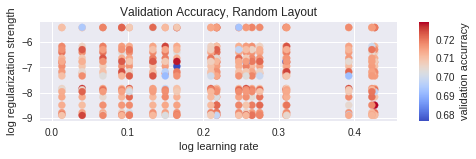

In [48]:
import math
from matplotlib import cm

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Plot validation accuracy.
colors = [results[x][1] for x in results]
plt.subplot(2, 1, 2)
p = plt.scatter(x_scatter, y_scatter, c=colors, cmap=cm.coolwarm)
cbar = plt.colorbar(p, aspect=10)
cbar.set_label('validation accurracy')
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Validation Accuracy, Random Layout')
plt.show()

## Visualize the cross-validation results in 3D

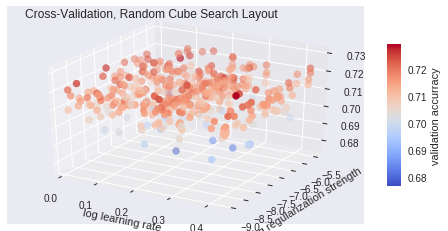

In [49]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = [math.log10(x[0]) for x in results]
Y = [math.log10(x[1]) for x in results]
Z = [results[x][1] for x in results]
p = ax.scatter(X, Y, Z, c=Z, s=50, cmap=cm.coolwarm)
cbar = plt.colorbar(p, shrink=0.65, aspect=10)
cbar.set_label('validation accurracy')
ax.set_xlabel('log learning rate')
ax.set_ylabel('log regularization strength')
ax.text2D(0.05, 0.95, "Cross-Validation, Random Cube Search Layout", fontsize=12, transform=ax.transAxes)
plt.show()

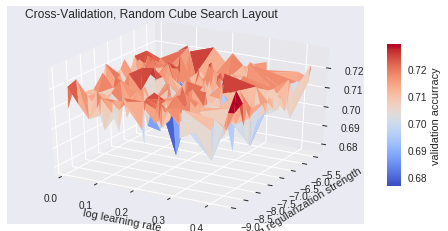

In [55]:
X = [math.log10(x[0]) for x in results]
Y = [math.log10(x[1]) for x in results]
Z = [results[x][1] for x in results]

ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, edgecolor='none');
cbar = plt.colorbar(p, shrink=0.65, aspect=10)
cbar.set_label('validation accurracy')
ax.set_xlabel('log learning rate')
ax.set_ylabel('log regularization strength')
ax.text2D(0.05, 0.95, "Cross-Validation, Random Cube Search Layout", fontsize=12, transform=ax.transAxes)
plt.show()

## Plot the loss function of the best network

Initial training loss (Softmax/CE expect: -ln(1/num_classes) = -ln(0.5) = 0.69315): 0.693147
Final training loss: 0.594105


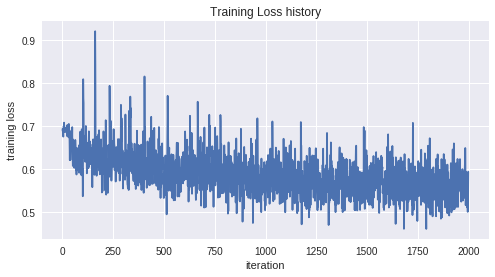

In [39]:
print('Initial training loss (Softmax/CE expect: -ln(1/num_classes) = -ln(0.5) = 0.69315): %f' 
      % (best_stats['loss_history'][0]))
print('Final training loss: %f' % (best_stats['loss_history'][-1]))

plt.plot(best_stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Plot the loss function and train / validation accuracies

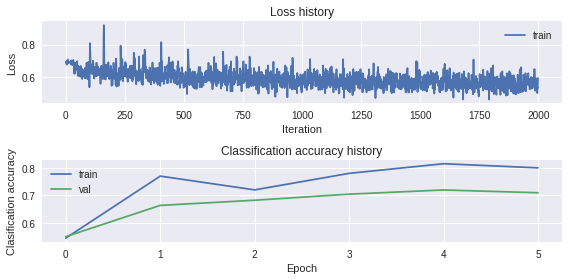

In [50]:
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'], label='train')
plt.legend()
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.legend()
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.tight_layout()
plt.show()

## Plot the weight/update ratio (around 1e-3)

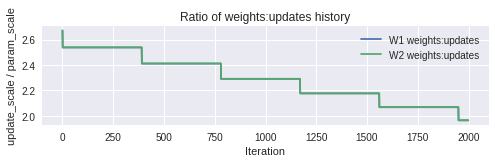

In [51]:
plt.subplot(2, 1, 2)
plt.plot(best_stats['weight_update_history_W1'], label='W1 weights:updates')
plt.plot(best_stats['weight_update_history_W2'], label='W2 weights:updates')
plt.legend()
plt.title('Ratio of weights:updates history')
plt.xlabel('Iteration')
plt.ylabel('update_scale / param_scale')
plt.show()

## Run on the test set

In [42]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

probs, logloss = best_net.predict_softmax(X_test, y_test)
print('Test Log Loss: %f' % (logloss))

Test accuracy:  0.7128
Test Log Loss: 0.570056


## Tuning LR Decay on the Best Net

iteration 0 / 4000: loss 0.544285
iteration 100 / 4000: loss 0.508851
iteration 200 / 4000: loss 0.495932
iteration 300 / 4000: loss 0.499225
iteration 400 / 4000: loss 0.513344
iteration 500 / 4000: loss 0.486618
iteration 600 / 4000: loss 0.493260
iteration 700 / 4000: loss 0.486181
iteration 800 / 4000: loss 0.492117
iteration 900 / 4000: loss 0.471298
iteration 1000 / 4000: loss 0.492060
iteration 1100 / 4000: loss 0.494090
iteration 1200 / 4000: loss 0.512168
iteration 1300 / 4000: loss 0.493385
iteration 1400 / 4000: loss 0.476146
iteration 1500 / 4000: loss 0.472328
iteration 1600 / 4000: loss 0.473890
iteration 1700 / 4000: loss 0.465080
iteration 1800 / 4000: loss 0.468768
iteration 1900 / 4000: loss 0.499991
iteration 2000 / 4000: loss 0.482762
iteration 2100 / 4000: loss 0.484060
iteration 2200 / 4000: loss 0.460465
iteration 2300 / 4000: loss 0.453074
iteration 2400 / 4000: loss 0.468518
iteration 2500 / 4000: loss 0.469902
iteration 2600 / 4000: loss 0.480003
iteration 270

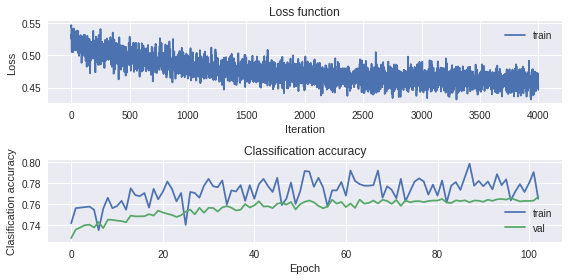

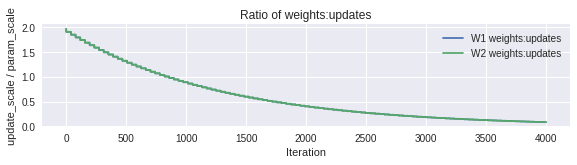

In [43]:
from neural_net import TwoLayerNet
from copy import deepcopy

input_size = k
num_classes = 2
std=1e-6
hidden_size = 400

t1 = time.time()
xnet = deepcopy(best_net)
xstats = xnet.train(X_train, y_train, X_val, y_val,
                   num_iters=4000, batch_size=2000,
                   learning_rate=best_stats['learning_rate'], learning_rate_decay=0.97,
                   reg=best_stats['reg'], verbose=True)
t2 = time.time()
val_acc = (xnet.predict(X_val) == y_val).mean()
print('Validation accuracy: %f, computed in %fs' % (val_acc, t2 - t1))
print('Final training loss: %f' % (xstats['loss_history'][-1]))
test_acc = (xnet.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

plt.subplot(2, 1, 1)
plt.plot(xstats['loss_history'], label='train')
plt.legend()
plt.title('Loss function')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(xstats['train_acc_history'], label='train')
plt.plot(xstats['val_acc_history'], label='val')
plt.legend()
plt.title('Classification accuracy')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.tight_layout()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(xstats['weight_update_history_W1'], label='W1 weights:updates')
plt.plot(xstats['weight_update_history_W2'], label='W2 weights:updates')
plt.legend()
plt.title('Ratio of weights:updates')
plt.xlabel('Iteration')
plt.ylabel('update_scale / param_scale')
plt.tight_layout()
plt.show()

In [52]:
# Softmax probabilities and Log Loss
probs, logloss = xnet.predict_softmax(X_test, y_test)
print('Test Log Loss: %f' % (logloss))

Test Log Loss: 0.495839


## Predict on the scoring set

In [0]:
def load_csv(file_path):
    df = pd.read_csv(file_path, delimiter=',', encoding='utf-8')
    print('Original df shape: ', df.shape)
    drop_list = [ \
                'Unnamed: 0', \
                'scoring_set.minor_line_yorn', \
                'scoring_set.customer_market_segment_name_Unknown Customer Market Segment', \
                #'scoring_set.software_yorn', \
                #'scoring_set.default_multi_year_discount_yorn', \
                #'scoring_set.four_quarter_bookings_band_$100k < Tier <= $250k', \
                #'scoring_set.four_quarter_bookings_band_$10m < Tier <= $25m', \
                #'scoring_set.four_quarter_bookings_band_$1m < Tier <= $5m', \
                #'scoring_set.four_quarter_bookings_band_$250k < Tier <= $500k', \
                #'scoring_set.four_quarter_bookings_band_$25m < Tier <= $50m', \
                #'scoring_set.four_quarter_bookings_band_$500k < Tier <= $1m', \
                #'scoring_set.four_quarter_bookings_band_$5m < Tier <= $10m', \
                #'scoring_set.four_quarter_bookings_band_Tier <= $100k', \
                #'scoring_set.four_quarter_bookings_band_Tier > $50m', \
                'scoring_set.product_route_to_market_2TIER', \
                'scoring_set.product_route_to_market_DIRECT', \
                'scoring_set.product_route_to_market_DVAR', \
                'scoring_set.product_route_to_market_OTHER', \
                'scoring_set.product_route_to_market_SP', \
                'scoring_set.service_route_to_market_code_2TIER', \
                'scoring_set.service_route_to_market_code_DIRECT', \
                'scoring_set.service_route_to_market_code_DVAR', \
                'scoring_set.service_route_to_market_code_OTHER', \
                'scoring_set.service_route_to_market_code_SP' \
                ]
    df.drop(drop_list, axis=1, inplace=True)
    df_data = df.loc[:, df.columns != 'scoring_set.innovation_challenge_key']
    df_key = df.loc[:, df.columns == 'scoring_set.innovation_challenge_key']
    X = df_data.values
    key = df_key.values
    key = key.ravel()
    del df_key
    del df_data
    del df
    return X, key

def get_csv_data():
    file_path = os.path.join('/hdfs/app/hadoop_sandbox/Sandbox213', 'pandas_cleanup_subm.csv')
    X_score, key = load_csv(file_path)
    # Mean normalize.
    mean_value = np.mean(X_train, axis=0)
    X_score -= mean_value
    # Feature scale.
    sigma = np.std(X_train, axis = 0)
    X_score = np.divide(X_score, sigma, out=np.zeros_like(X_score), where=sigma!=0)
    return X_score, key

X_score, challenge_keys = get_csv_data()
print('Train and score must have the same dimension D:')
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Score data shape: ', X_score.shape)
print('Score key shape: ', challenge_keys.shape)

FileNotFoundError: File b'/hdfs/app/hadoop_sandbox/Sandbox213/pandas_cleanup_subm.csv' does not exist

In [0]:
# Softmax probabilities
probs = xnet.predict_softmax_p(X_score)
print('Score probabilities shape: ', probs.shape)
print(probs)

Score probabilities shape:  (1876903,)
[0.73850364 0.74135232 0.73850364 ... 0.61220564 0.84492023 0.67567698]


In [0]:
# Creating the submission file
def write_submission_file(df):
    file_path = os.path.join('/hdfs/app/hadoop_sandbox/Sandbox213', 'submission_file.csv')
    try:
        os.remove(file_path)
    except OSError:
        pass
    df.to_csv(file_path, index=False)

df_submit = pd.DataFrame()
df_submit['INNOVATION_CHALLENGE_KEY'] = challenge_keys
df_submit['RENEWAL_PROBABLIITY'] = probs
df_submit.sort_values(by='INNOVATION_CHALLENGE_KEY', ascending=True, inplace=True)
write_submission_file(df_submit)
print(df_submit.head(20))
print(df_submit.tail(20))
del df_submit

    INNOVATION_CHALLENGE_KEY  RENEWAL_PROBABLIITY
0                    5849735             0.738504
1                    7111156             0.741352
2                    2633184             0.738504
3                    7349534             0.741352
4                    6947927             0.738504
5                    7505928             0.648274
6                    5091305             0.738690
7                    4426248             0.738504
8                    7669714             0.648274
9                    6405053             0.738504
10                   3892357             0.738504
11                   6556546             0.581376
12                   5305623             0.738690
13                   6017242             0.581376
14                   4731917             0.601166
15                    186150             0.601166
16                   5757555             0.601166
17                   7703845             0.601166
18                   5931575             0.733061
